# Experimental Data Simulation 
* Can do this using GPs, which are nice because covariance function gives me easy control over smoothness and heteroskedasticity 

In [248]:
# Generation
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 
import GPy
import pandas as pd 

# Simulation 
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.formula.api as smf 

# Exploration
from scipy.stats import qmc
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from tqdm import tqdm 

In [180]:
def plot_mesh(Xi, Xj, values):
    plt.figure()
    plt.pcolormesh(Xi, Xj, np.array(values).reshape(Xi.shape))
    plt.colorbar()

 <ipython-input-180-5963553617bf>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(0.5, 1.0, 'Noise')

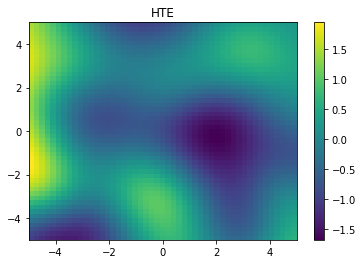

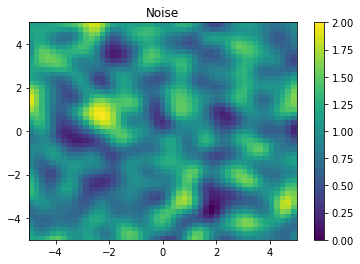

In [254]:
plot_mesh(Xi, Xj, df["exp8_effect"])
plt.title("HTE")

plot_mesh(Xi, Xj, df["exp8_noise"])
plt.title("Noise")

# Use GPs to create noise and HTE patterns 

In [123]:
[Xi, Xj] = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
Xcoords = np.vstack((Xi.ravel(), Xj.ravel())).T


n_samples = 10

# HTE generation
k = GPy.kern.RBF(input_dim=2)
k.lengthscale = 2

mu = np.zeros(Xcoords.shape[0])
cov = k.K(Xcoords, Xcoords)
hte_samples = np.random.multivariate_normal(mu, cov, n_samples)

# Variance generation
k = GPy.kern.RBF(input_dim=2)
k.lengthscale = 0.5
k.variance = 10

mu = np.zeros(Xcoords.shape[0])
cov = k.K(Xcoords, Xcoords)
noise_var_samples = np.random.multivariate_normal(mu, cov, n_samples)

In [269]:
df = pd.DataFrame(np.concatenate([Xcoords, hte_samples.T, noise_var_samples.T], axis=1), 
                  columns=["design_param1", "design_param2"]+[f"exp{i}_effect" for i in range(n_samples)]+[f"exp{i}_noise" for i in range(n_samples)])


minmax_scaler = MinMaxScaler()
df.loc[:, df.filter(like="noise").columns] = minmax_scaler.fit_transform(df.filter(like="noise")) * 1.5


knn_models = {}

for colname in df.filter(like="exp").columns: 
    knn_models[colname] = KNeighborsRegressor(n_neighbors=1).fit(X=df[['design_param1', 'design_param2']], y=df[colname])

In [166]:
def run_experiment(design_param1, design_param2, n_trials, exp_num=0):
    effect = knn_models[f"exp{exp_num}_effect"].predict(np.array([design_param1, design_param2]).reshape(1,-1))[0]
    noise = knn_models[f"exp{exp_num}_noise"].predict(np.array([design_param1, design_param2]).reshape(1,-1))[0]
    
    df_exp = pd.DataFrame({"treatment":[1]*n_trials + [0]*n_trials})
    df_exp['y'] = np.random.normal(loc=df_exp['treatment']*effect, scale=noise)
    model = smf.ols("y ~ treatment", data=df_exp).fit()
    return model.params["treatment"], model.bse["treatment"], effect
    

# Explore the space 

In [224]:
trial_budget = 500 
n_experiments = np.arange(10, 100, 5)
n_trials_per_exp = trial_budget // n_experiments

In [249]:
mse = []
df_metaexp = pd.DataFrame({"n_experiments":n_experiments, "n_trials_per_exp":n_trials_per_exp})
exp_sim_id = 0

for row in tqdm(df_metaexp.itertuples()):
    sobol_sampler = qmc.Sobol(d=2, scramble=True, seed=2022)
    sobol_sample = (sobol_sampler.random_base2(m=int(np.log2(row.n_experiments))) - 0.5) * 5/0.5
    df_explore = pd.DataFrame(sobol_sample, columns=["design_param1", "design_param2"])
    df_explore["exp_estimate"] = df_explore.apply(lambda x: run_experiment(x.design_param1, x.design_param2, row.n_trials_per_exp, exp_sim_id)[0], axis=1)
    rf = RandomForestRegressor().fit(X=df_explore[["design_param1", "design_param2"]], y=df_explore["exp_estimate"])
    
    mse.append(r2_score(y_true=df[f"exp{exp_sim_id}_effect"], y_pred=rf.predict(df[["design_param1", "design_param2"]])))
    
df_metaexp['mse'] = mse

18it [00:06,  3.00it/s]


100%|██████████| 10/10 [01:08<00:00,  6.81s/it]


Text(0, 0.5, 'MSE')

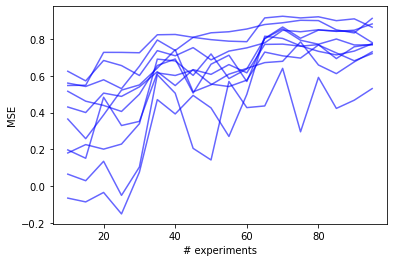

In [270]:
mse_master = []

for exp_sim_id in tqdm(range(10)):
    mse = []
    df_metaexp = pd.DataFrame({"n_experiments":n_experiments, "n_trials_per_exp":n_trials_per_exp})


    for row in df_metaexp.itertuples():
        sobol_sampler = qmc.Sobol(d=2, scramble=True, seed=2022)
        sobol_sample = (sobol_sampler.random_base2(m=int(np.log2(row.n_experiments))) - 0.5) * 5/0.5
        df_explore = pd.DataFrame(sobol_sample, columns=["design_param1", "design_param2"])
        df_explore["exp_estimate"] = df_explore.apply(lambda x: run_experiment(x.design_param1, x.design_param2, row.n_trials_per_exp, exp_sim_id)[0], axis=1)
        rf = RandomForestRegressor().fit(X=df_explore[["design_param1", "design_param2"]], y=df_explore["exp_estimate"])

        mse.append(r2_score(y_true=df[f"exp{exp_sim_id}_effect"], y_pred=rf.predict(df[["design_param1", "design_param2"]])))

    mse_master.append(mse)
    df_metaexp['mse'] = mse
    plt.plot(df_metaexp["n_experiments"], df_metaexp["mse"], color="blue", alpha=0.6)
    
plt.xlabel("# experiments")
plt.ylabel("MSE")

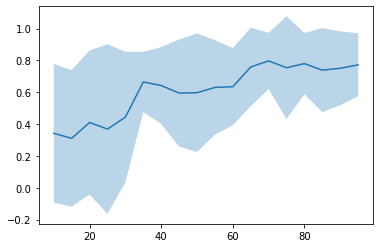

In [271]:
plt.plot(df_metaexp['n_experiments'], np.array(mse_master).mean(axis=0))
plt.fill_between(x=df_metaexp['n_experiments'], 
                 y1=np.array(mse_master).mean(axis=0) - 1.96*np.array(mse_master).std(axis=0),
                 y2=np.array(mse_master).mean(axis=0) + 1.96*np.array(mse_master).std(axis=0), alpha=0.3)

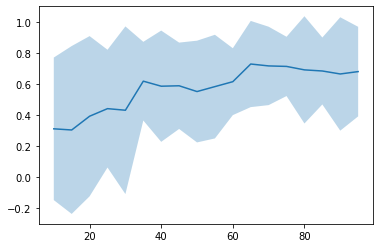

In [268]:
plt.plot(df_metaexp['n_experiments'], np.array(mse_master).mean(axis=0))
plt.fill_between(x=df_metaexp['n_experiments'], 
                 y1=np.array(mse_master).mean(axis=0) - 1.96*np.array(mse_master).std(axis=0),
                 y2=np.array(mse_master).mean(axis=0) + 1.96*np.array(mse_master).std(axis=0), alpha=0.3)

In [208]:
df_explore = pd.DataFrame(sobol_sample, columns=["design_param1", "design_param2"])
df_explore["exp_estimate"] = df_explore.apply(lambda x: run_experiment(x.design_param1, x.design_param2, 1000, 1)[0], axis=1)

In [209]:
rf = RandomForestRegressor().fit(X=df_explore[["design_param1", "design_param2"]], y=df_explore["exp_estimate"])

 <ipython-input-180-5963553617bf>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-180-5963553617bf>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


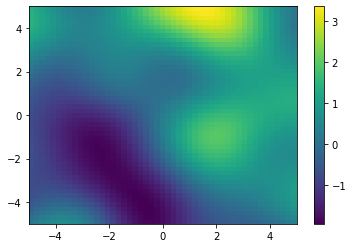

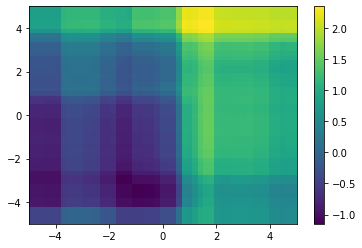

In [210]:
plot_mesh(Xi, Xj, df["exp1_effect"])
plot_mesh(Xi, Xj, rf.predict(df[["design_param1", "design_param2"]]))

 <ipython-input-180-5963553617bf>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


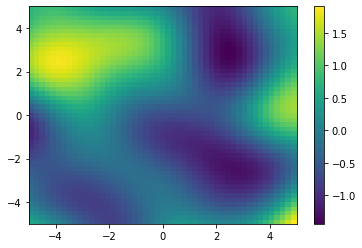

In [197]:
plot_mesh(Xi, Xj, df["exp0_effect"])

 <ipython-input-180-5963553617bf>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


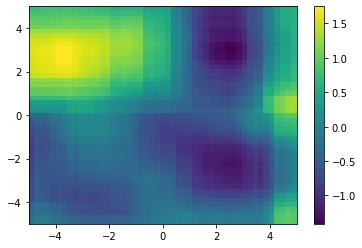

In [202]:
plot_mesh(Xi, Xj, rf.predict(df[["design_param1", "design_param2"]]))

 <ipython-input-180-5963553617bf>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


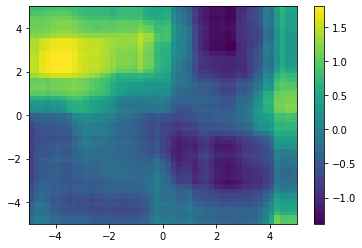

In [199]:
plot_mesh(Xi, Xj, rf.predict(df[["design_param1", "design_param2"]]))

# OLD

In [1]:
# Support for maths


# import warnings
# warnings.filterwarnings('ignore')




In [2]:
k = GPy.kern.RBF(1)

In [3]:
X = np.linspace(-4.,4.,100)[:, None]

 <ipython-input-17-3b8eb6d41f8d>:5: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


(None, (-4.0, 4.0, 4.0, -4.0))

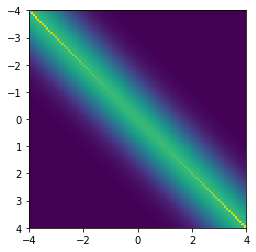

In [17]:
# The kernel takes two inputs, and outputs the covariance between each respective point in the two inputs
K = k.K(X,X) + np.eye(100) * X ** 2 / 32 # K is PSD by construction

# Plot the covariance of the sample space
plt.pcolor(X.T, X, K)
plt.gca().invert_yaxis(), plt.gca().axis("image")


# Format and annotate plot

# plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
# plt.title("$\kappa_{rbf}(x,x')$");

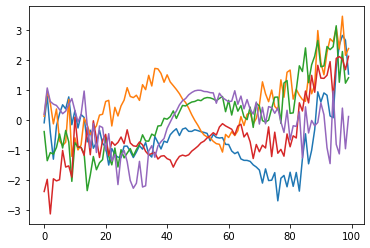

In [34]:
mu = np.zeros(100)
sample_1d = np.random.multivariate_normal(mu, K, 5)

for trace in sample_1d:
    plt.plot(trace)

In [33]:
for i in sample_1d: 
    print(i)

[-1.73675353e+00 -2.25992165e+00 -1.32018550e+00 -1.58145051e+00
 -2.48309069e+00 -2.53077427e+00 -3.01594719e+00 -1.44513479e+00
 -3.06772867e+00 -2.15000008e+00 -2.90429948e+00 -2.21248430e+00
 -1.28279180e+00 -1.67335999e+00 -1.98150775e+00 -2.47402447e+00
 -1.99576225e+00 -1.16714687e+00 -1.07183815e+00 -1.39676754e+00
 -6.86650941e-01 -2.29239211e+00 -1.30908146e+00 -1.90115730e+00
 -1.17645665e+00 -1.85983946e+00 -1.13511884e+00 -9.72620261e-01
 -1.00129040e+00 -1.15185018e+00 -8.78645233e-01 -9.21536646e-01
 -4.01471428e-01 -1.07321478e+00 -1.38598590e+00 -8.10469425e-01
 -1.10578202e+00 -1.17952006e+00 -1.29937642e+00 -1.33327369e+00
 -1.14987299e+00 -1.24461656e+00 -1.48561434e+00 -1.47329204e+00
 -1.43721421e+00 -1.28890493e+00 -1.25920890e+00 -1.22951462e+00
 -1.15713918e+00 -1.02525196e+00 -9.56469988e-01 -8.41562118e-01
 -7.28748932e-01 -5.23225086e-01 -5.36607337e-01 -4.55888009e-01
 -3.96952982e-01 -1.45457841e-01  1.26382651e-01  1.32251958e-01
  8.43952311e-02  2.44601

array([[-3.03616774, -1.51370981, -2.25205175, -0.97859023, -1.40207791,
        -1.96601251, -1.69044473, -0.34819361, -0.53916173, -1.44066223,
        -1.14747531,  0.56498132, -0.84003259, -0.90175248, -1.16236528,
        -1.22219933, -0.79171042, -0.03743956, -1.02519856, -0.28266486,
        -0.3399073 , -0.93353393, -1.04655753, -1.46846879, -1.03535572,
        -1.46712915, -1.95471423, -1.25115536, -1.31427289, -1.04319638,
        -1.29460265, -1.20460841, -1.89354286, -1.29738811, -0.96734547,
        -0.97313883, -1.28640038, -1.26350862, -1.45558561, -1.20513767,
        -1.25437706, -1.32755455, -1.16388093, -1.03016218, -1.34332091,
        -1.36813591, -1.23199328, -1.28749728, -1.35044683, -1.33954895,
        -1.33015048, -1.30812025, -1.27530653, -1.23578142, -1.13371118,
        -1.08711881, -1.00868795, -0.93072329, -0.93537742, -0.89856719,
        -0.68934604, -0.82439118, -0.4239228 , -0.38457905, -0.66133505,
        -0.49495219,  0.06717427, -0.10191085,  0.3

In [20]:
np.all(np.linalg.eig(np.eye(100) * X ** 2 / 32)[0] > 0) 

True

# 2D

In [92]:
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
Xcoords = np.vstack((Xi.ravel(), Xj.ravel())).T

k = GPy.kern.RBF(input_dim=2)
k.lengthscale = 0.5

mu = np.zeros(Xcoords.shape[0])
cov = k.K(Xcoords, Xcoords)
sample = np.random.multivariate_normal(mu, cov, 30)

In [75]:
mu = np.zeros(Xcoords.shape[0])
cov = k.K(Xcoords, Xcoords) + np.eye(2500) * np.linspace(-1,1,2500)**2 / 1
sample = np.random.multivariate_normal(mu, cov, 1)

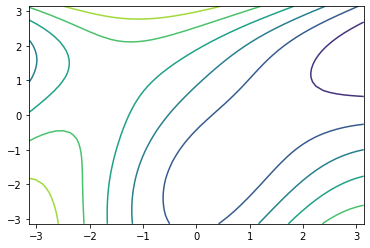

In [72]:
plt.contour(Xi, Xj, sample.reshape(Xi.shape))

 <ipython-input-91-135f4e0dc5f7>:3: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-91-135f4e0dc5f7>:2: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


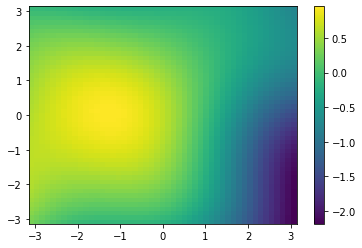

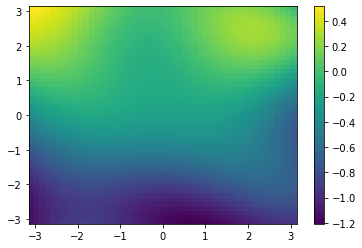

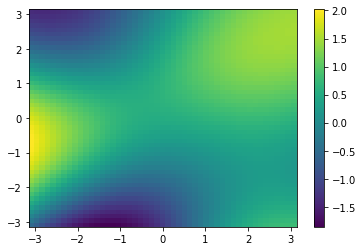

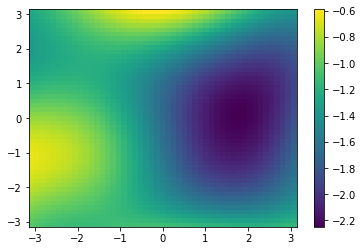

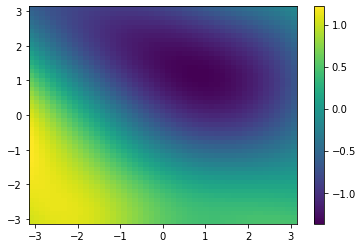

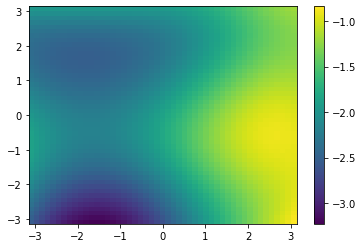

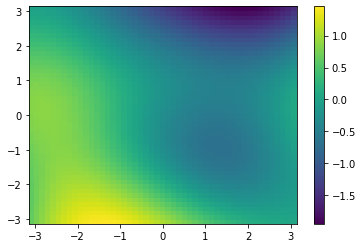

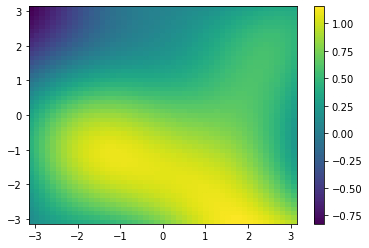

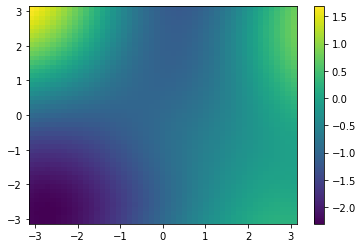

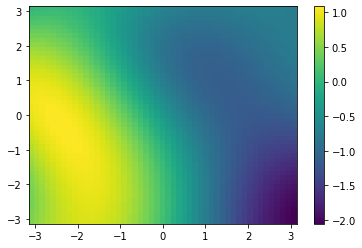

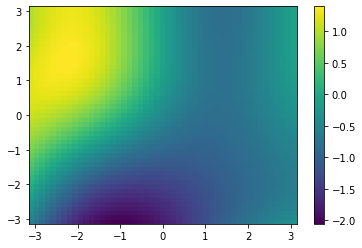

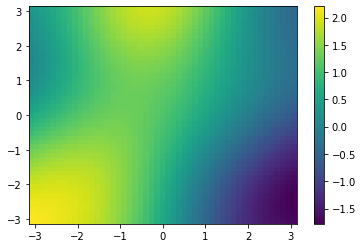

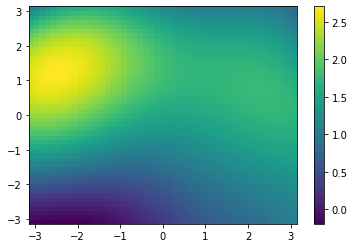

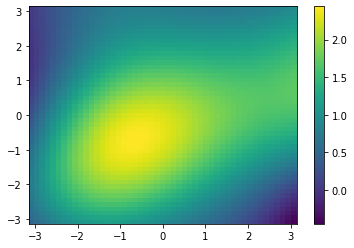

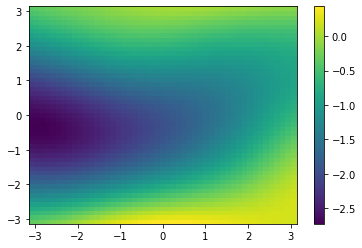

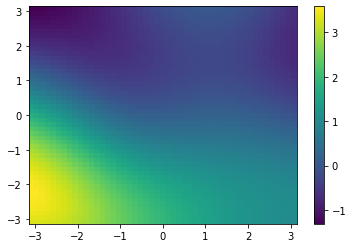

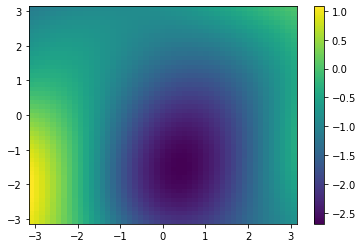

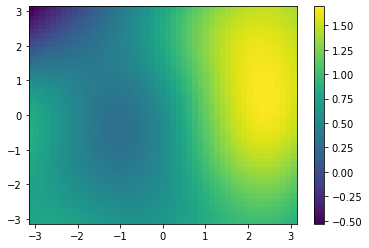

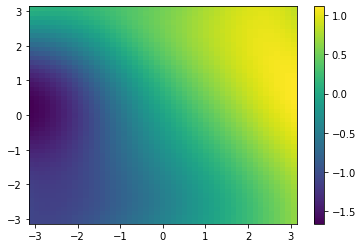

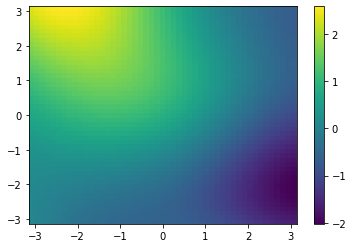

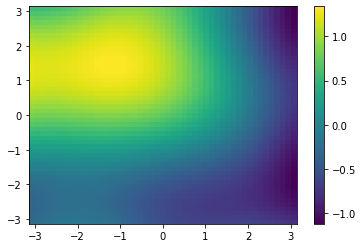

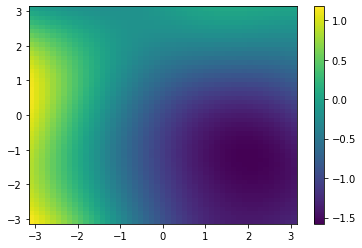

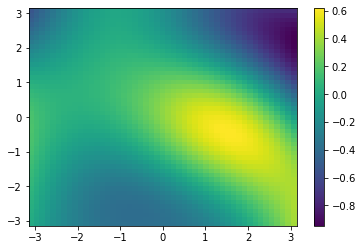

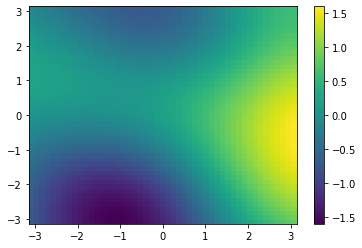

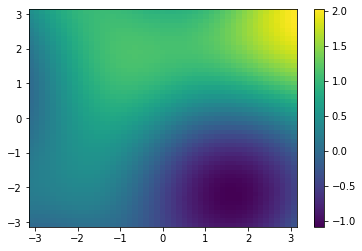

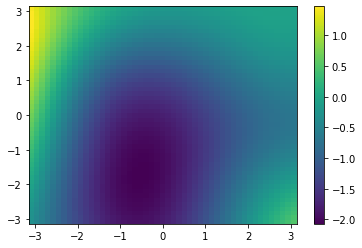

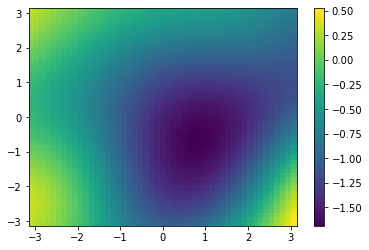

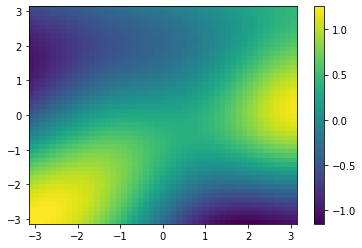

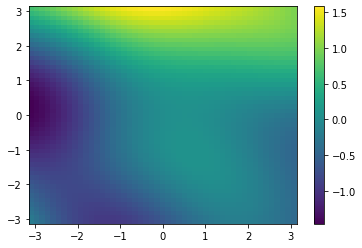

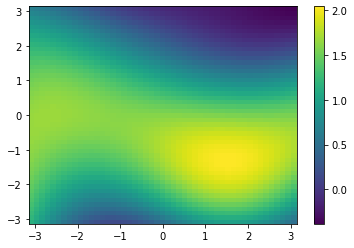

In [91]:
for i in range(30):
    plt.figure()
    plt.pcolormesh(Xi, Xj, sample[i,:].reshape(Xi.shape))
    plt.colorbar()

 <ipython-input-103-0f91d1f5e39e>:14: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
 <ipython-input-103-0f91d1f5e39e>:13: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


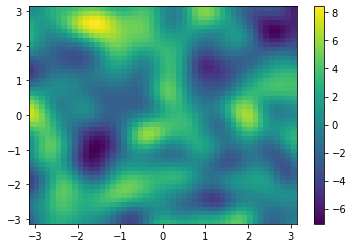

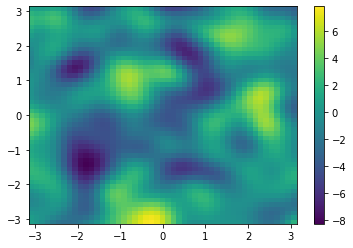

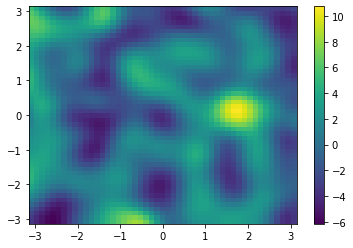

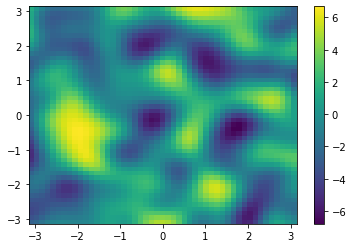

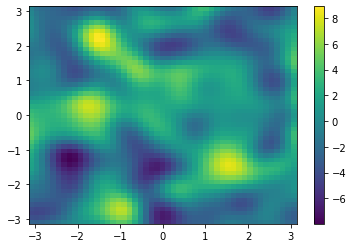

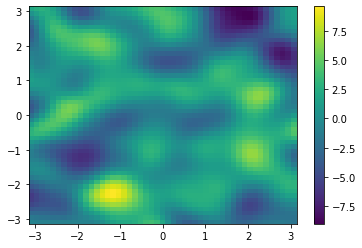

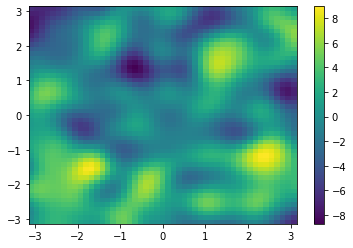

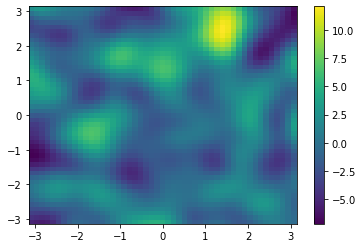

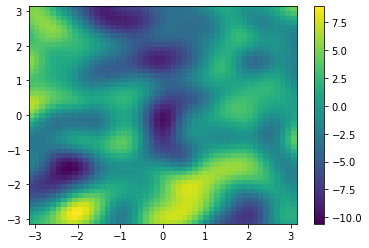

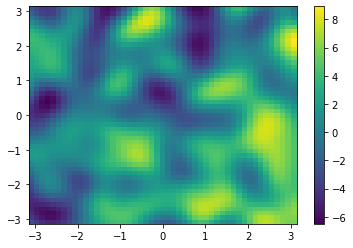

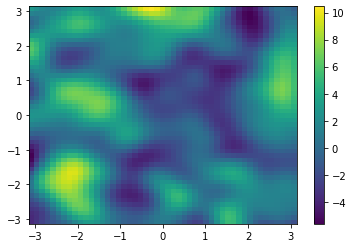

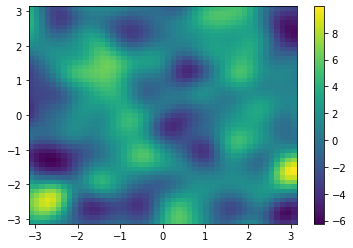

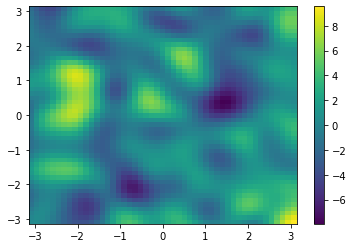

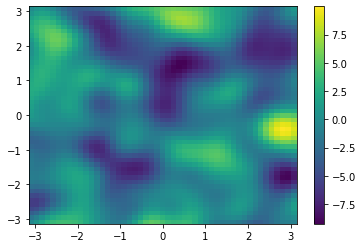

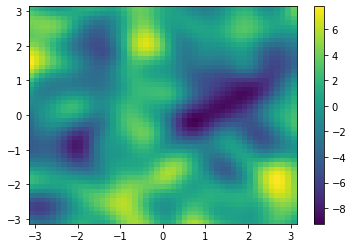

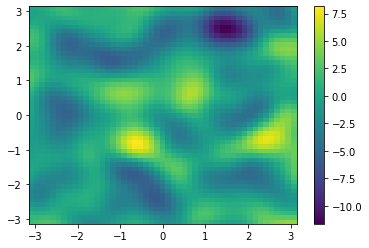

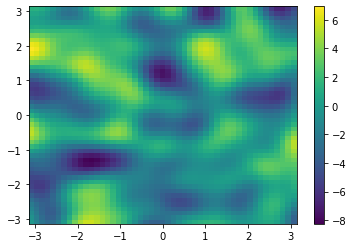

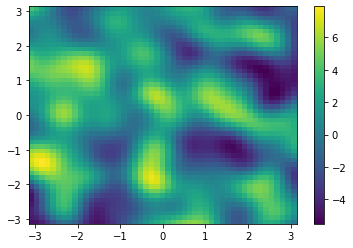

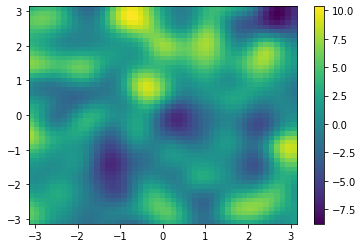

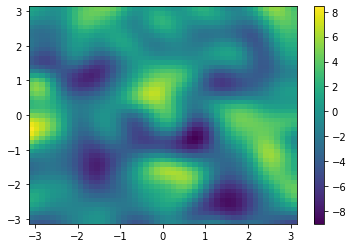

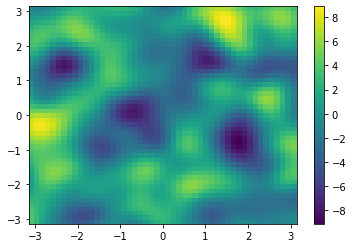

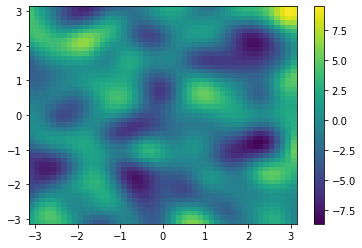

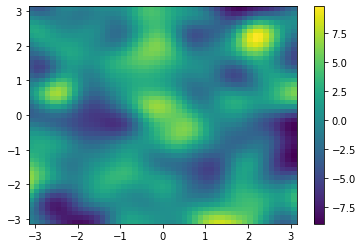

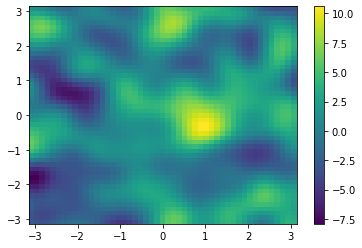

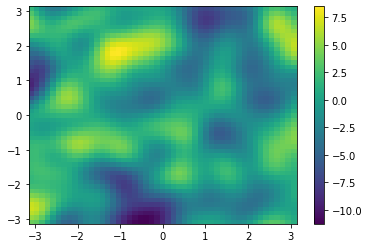

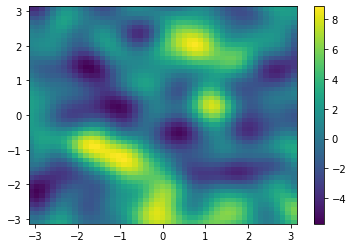

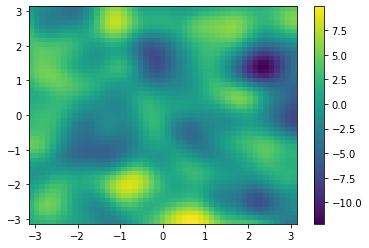

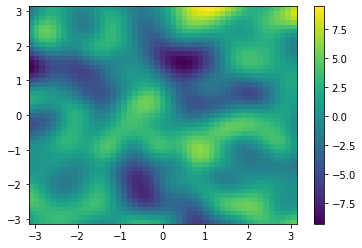

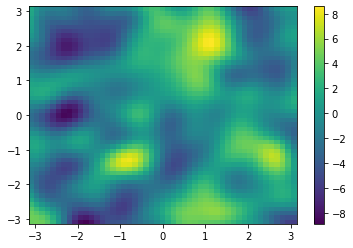

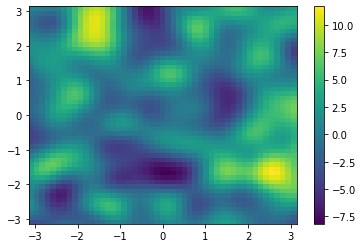

In [103]:
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
Xcoords = np.vstack((Xi.ravel(), Xj.ravel())).T

k = GPy.kern.RBF(input_dim=2)
k.lengthscale = 0.5
k.variance = 10

mu = np.zeros(Xcoords.shape[0])
cov = k.K(Xcoords, Xcoords)
sample = np.random.multivariate_normal(mu, cov, 30)

for i in range(30):
    plt.figure()
    plt.pcolormesh(Xi, Xj, sample[i,:].reshape(Xi.shape))
    plt.colorbar()

 <ipython-input-87-df55abe8ec55>:1: MatplotlibDeprecationWarning:shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


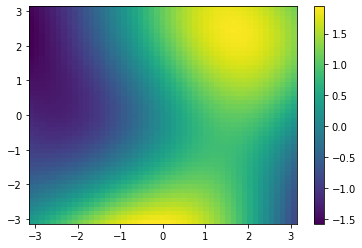

In [87]:
plt.pcolormesh(Xi, Xj, sample.reshape(Xi.shape))
plt.colorbar()

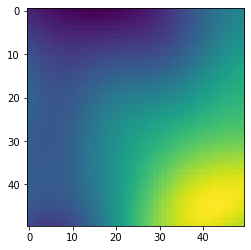

In [82]:
plt.imshow(sample.reshape(Xi.shape))

In [37]:
Xj.shape

(50, 50)

In [38]:
Xj[:,0]

array([-3.14159265, -3.01336438, -2.88513611, -2.75690784, -2.62867957,
       -2.5004513 , -2.37222302, -2.24399475, -2.11576648, -1.98753821,
       -1.85930994, -1.73108167, -1.60285339, -1.47462512, -1.34639685,
       -1.21816858, -1.08994031, -0.96171204, -0.83348377, -0.70525549,
       -0.57702722, -0.44879895, -0.32057068, -0.19234241, -0.06411414,
        0.06411414,  0.19234241,  0.32057068,  0.44879895,  0.57702722,
        0.70525549,  0.83348377,  0.96171204,  1.08994031,  1.21816858,
        1.34639685,  1.47462512,  1.60285339,  1.73108167,  1.85930994,
        1.98753821,  2.11576648,  2.24399475,  2.37222302,  2.5004513 ,
        2.62867957,  2.75690784,  2.88513611,  3.01336438,  3.14159265])

In [39]:
Xi[:,0]

array([-3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
       -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265])